<a id="2"></a>
<h2 style="color:#ccb2d3;font-size:55px;font-family:Georgia;text-align:center;"><strong> <strong style="color:black;font-size:50px;font-family:Georgia;">Introduction </strong></strong></h2>


<p style= "background-color:#f6f6f6;font-family:Georgia;color:##b8e1f0;font-size:110%;text-align:center;border-radius:10px 10px;border-style: dotted;border-width:5px;border-color:##b8e1f0;">
    <b><br>
<br>
In the pursuit of enhancing communication for the Arabic-speaking deaf community, we have embarked on an Arabic Sign Language recognition AI project. This project leverages a comprehensive dataset encompassing 190 distinct classes of signs, which include numbers, letters, words, and verbs. For the initial phase, we focus on recognizing 90 classes comprising numbers and letters only. By employing a Bidirectional Long Short-Term Memory (BiLSTM) model, our aim is to accurately interpret these signs, thereby laying a robust foundation for future expansion to encompass a broader range of vocabulary in Arabic Sign Language.<br>
    
    

In [ ]:
!pip install mediapipe

In [ ]:
import mediapipe as mp
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
import os
import shutil
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import glob
import cv2
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Bidirectional, LSTM, Dense, Attention, Dropout,Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score,classification_report,confusion_matrix
from sklearn.model_selection import train_test_split
np.random.seed(42)

---

# **1.Getting Data**

In [ ]:
os.environ['KAGGLE_CONFIG_DIR'] = '/content'

In [ ]:
!kaggle datasets download -d ashrakatsaeed/data-010

In [ ]:
! unzip /content/data-010.zip

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

---

# **2.Keypoints using MP Holistic**

In [ ]:
# Create a Holistic object to detect pose, face, and hands keypoints
mp_holistic = mp.solutions.holistic

# Drawing utilities
mp_drawing = mp.solutions.drawing_utils

In [ ]:
def mediapipe_detection(image, model):

    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [ ]:
def draw_styled_landmarks(image, results):

    # Draw pose connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(80,22,10), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(80,44,121), thickness=2, circle_radius=2)
                             )
    # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(121,22,76), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(121,44,250), thickness=2, circle_radius=2)
                             )
    # Draw right hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                             mp_drawing.DrawingSpec(color=(245,117,66), thickness=2, circle_radius=4),
                             mp_drawing.DrawingSpec(color=(245,66,230), thickness=2, circle_radius=2)
                             )

In [ ]:
def adjust_landmarks(arr,center):

    # Reshape the array to have shape (n, 3)
    arr_reshaped = arr.reshape(-1, 3)

    # Repeat the center array to have shape (n, 3)
    center_repeated = np.tile(center, (len(arr_reshaped), 1))

    # Subtract the center array from the arr array
    arr_adjusted = arr_reshaped - center_repeated

    # Reshape arr_adjusted back to shape (n*3,)
    arr_adjusted = arr_adjusted.reshape(-1)
    return(arr_adjusted)

---

# **3.Extract Keypionts**

In [ ]:
def extract_keypoints(results):

    pose = np.array([[res.x, res.y, res.z] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    nose=pose[:3]
    lh_wrist=lh[:3]
    rh_wrist=rh[:3]
    pose_adjusted = adjust_landmarks(pose,nose)
    lh_adjusted = adjust_landmarks(lh,lh_wrist)
    rh_adjusted = adjust_landmarks(rh,rh_wrist)
    return pose_adjusted, lh_adjusted, rh_adjusted

---

# **4. Save Keypionts in array**

In [ ]:
selected_words = [str(num).zfill(4) for num in range(1,71)]


In [ ]:
def make_keypoint_arrays(path,signer,split):
    """This function generates numpy arrays of keypoints for each video in the specified folder location.
    Args:
      signer(int): the signer of interest. Could be 01 or 02 or 03
      split(str): can be 'train', 'test' or 'val'
    """
    os.makedirs('karsl-502',exist_ok = True)
    os.makedirs(f'karsl-502/{signer}',exist_ok = True)
    os.makedirs(f'karsl-502/{signer}/{split}',exist_ok = True)
    working_path = f'karsl-502/{signer}/{split}'
    words_folder = os.path.join(path,str(signer),str(signer), split)

    # Loop through all the subfolders in the folder
    for word in tqdm(selected_words):

        video_files = os.listdir(os.path.join(words_folder, word))
          # Loop through the video files
        for video_file in video_files:
                # Open the video file
            video = sorted(os.listdir(os.path.join(words_folder, word, video_file)))

            # Initialize the list of keypoints for this video
            pose_keypoints, lh_keypoints, rh_keypoints = [], [], []
            with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
              # Loop through the video frames
              for frame in video:
                  # Perform any necessary preprocessing on the frame (e.g., resizing, normalization)
                frame = os.path.join(words_folder, word, video_file,frame)
                frame = cv2.imread(frame)
#                 frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

                  # Normalize pixel values to the range [0, 1]
                # Make detections
                image, results = mediapipe_detection(frame, holistic)

                # Extract keypoints
                pose, lh, rh = extract_keypoints(results)
                # Add the keypoints to the list for this video
                pose_keypoints.append(pose)
                lh_keypoints.append(lh)
                rh_keypoints.append(rh)
                # Save the keypoints for this video to a numpy array
                pose_directory = os.path.join(working_path, word,'pose_keypoints')
                lh_directory = os.path.join(working_path, word,'lh_keypoints')
                rh_directory = os.path.join(working_path, word,'rh_keypoints')

                if not os.path.exists(pose_directory):
                    os.makedirs(pose_directory)

                if not os.path.exists(lh_directory):
                    os.makedirs(lh_directory)

                if not os.path.exists(rh_directory):
                    os.makedirs(rh_directory)

                pose_path = os.path.join(pose_directory, video_file)
                np.save(pose_path, pose_keypoints)

                lh_path = os.path.join(lh_directory, video_file)
                np.save(lh_path, lh_keypoints)

                rh_path = os.path.join(rh_directory, video_file)
                np.save(rh_path, rh_keypoints)

In [ ]:
data_path = "/content/data"
make_keypoint_arrays(data_path,'01','train/0001-0071')

In [ ]:
make_keypoint_arrays(data_path,'01','test/000-0071')

---

# **5. Labels Mapping**

In [ ]:
karsl_df = pd.read_excel('/content/KARSL-190_Labels.xlsx')
mask = []
for i in karsl_df['SignID'].values:
    if str(i).zfill(4) in selected_words :
        mask.append(True)
    else :
        mask.append(False)

karsl_6 = karsl_df[mask].reset_index(drop=True)

karsl_6

,SignID,Sign-Arabic,Sign-English
0,1,0,0
1,2,1,1
2,3,2,2
3,4,3,3
4,5,4,4
...,...,...,...
65,66,إ,alif with hamza below
66,67,آ,ALif with maad
67,68,ى,Alif maqsoura
68,69,لا,laam Alif


In [ ]:
w2id = {w:i for w,i in zip(karsl_6['Sign-Arabic'].values,karsl_6['SignID'].values  )}
w2id

{0: 1,
 1: 2,
 2: 3,
 3: 4,
 4: 5,
 5: 6,
 6: 7,
 7: 8,
 8: 9,
 9: 10,
 10: 11,
 20: 12,
 30: 13,
 40: 14,
 50: 15,
 60: 16,
 70: 17,
 80: 18,
 90: 19,
 100: 20,
 200: 21,
 300: 22,
 400: 23,
 500: 24,
 600: 25,
 700: 26,
 800: 27,
 900: 28,
 1000: 29,
 1000000: 30,
 10000000: 31,
 'ا': 32,
 'ب': 33,
 'ت': 34,
 'ث': 35,
 'ج': 36,
 'ح': 37,
 'خ': 38,
 'د': 39,
 'ذ': 40,
 'ر': 41,
 'ز': 42,
 'س': 43,
 'ش': 44,
 'ص': 45,
 'ض': 46,
 'ط': 47,
 'ظ': 48,
 'ع': 49,
 'غ': 50,
 'ف': 51,
 'ق': 52,
 'ك': 53,
 'ل': 54,
 'م': 55,
 'ن': 56,
 'ه': 57,
 'و': 58,
 'ي': 59,
 'ة': 60,
 'أ': 61,
 'ؤ': 62,
 'ئ': 63,
 'ئـ': 64,
 'ء': 65,
 'إ': 66,
 'آ': 67,
 'ى': 68,
 'لا': 69,
 'ال': 70}

In [ ]:
words2= np.array([v for v in karsl_6['Sign-Arabic']])
print(words2)

['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' '10' '20' '30' '40' '50' '60'

 '70' '80' '90' '100' '200' '300' '400' '500' '600' '700' '800' '900'

 '1000' '1000000' '10000000' 'ا' 'ب' 'ت' 'ث' 'ج' 'ح' 'خ' 'د' 'ذ' 'ر' 'ز'

 'س' 'ش' 'ص' 'ض' 'ط' 'ظ' 'ع' 'غ' 'ف' 'ق' 'ك' 'ل' 'م' 'ن' 'ه' 'و' 'ي' 'ة'

 'أ' 'ؤ' 'ئ' 'ئـ' 'ء' 'إ' 'آ' 'ى' 'لا' 'ال']


In [ ]:
label_map = {label:num for num, label in enumerate(words2)}
print(label_map)

{'0': 0, '1': 1, '2': 2, '3': 3, '4': 4, '5': 5, '6': 6, '7': 7, '8': 8, '9': 9, '10': 10, '20': 11, '30': 12, '40': 13, '50': 14, '60': 15, '70': 16, '80': 17, '90': 18, '100': 19, '200': 20, '300': 21, '400': 22, '500': 23, '600': 24, '700': 25, '800': 26, '900': 27, '1000': 28, '1000000': 29, '10000000': 30, 'ا': 31, 'ب': 32, 'ت': 33, 'ث': 34, 'ج': 35, 'ح': 36, 'خ': 37, 'د': 38, 'ذ': 39, 'ر': 40, 'ز': 41, 'س': 42, 'ش': 43, 'ص': 44, 'ض': 45, 'ط': 46, 'ظ': 47, 'ع': 48, 'غ': 49, 'ف': 50, 'ق': 51, 'ك': 52, 'ل': 53, 'م': 54, 'ن': 55, 'ه': 56, 'و': 57, 'ي': 58, 'ة': 59, 'أ': 60, 'ؤ': 61, 'ئ': 62, 'ئـ': 63, 'ء': 64, 'إ': 65, 'آ': 66, 'ى': 67, 'لا': 68, 'ال': 69}


# **6.Preprocessing Data**

In [ ]:
w2id = {str(key): value for key, value in w2id.items()}   ## Notice : I made the keys of w2id as str to debug the error :)

In [ ]:
def preprocess_data(data_path,signers,split,f_avg):

    # Initialize the lists of sequences and labels
    sequences, labels = [], []

    # Iterate through the list of words
    for word in tqdm(words2):
        for signer in signers:
            # Iterate through the numpy arrays contained in the directory mentioned below
            for sequence in os.listdir(os.path.join(data_path,signer, split, str(w2id[word]).zfill(2).zfill(4), 'lh_keypoints')):
                 # Load the left hand array
                res_lh = np.load(os.path.join(data_path,str(signer), split, str(w2id[word] ).zfill(4), 'lh_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_lh.shape[0], f_avg)
                res_lh = res_lh[:num_frames,:]
                while num_frames < f_avg:
                    res_lh = np.concatenate((res_lh, np.expand_dims(res_lh[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Load the right hand array
                res_rh = np.load(os.path.join(data_path,str(signer), split, str(w2id[word]).zfill(4), 'rh_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_rh.shape[0], f_avg)
                res_rh = res_rh[:num_frames,:]
                while num_frames < f_avg:
                    res_rh = np.concatenate((res_rh, np.expand_dims(res_rh[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Load the pose array
                res_pose = np.load(os.path.join(data_path,str(signer), split, str(w2id[word]).zfill(4), 'pose_keypoints', sequence))

                # Determine how many rows to select
                num_frames = min(res_pose.shape[0], f_avg)
                res_pose = res_pose[:num_frames,:]
                while num_frames < f_avg:
                    res_pose = np.concatenate((res_pose, np.expand_dims(res_pose[-1,:], axis=0)), axis=0)
                    num_frames += 1

                # Append the subsequence to the list of sequences
                sequences.append(np.concatenate((res_pose,res_lh, res_rh), axis=1))
                # Append the label to the list of labels
                labels.append(label_map[word])
    # Convert the lists of sequences and labels to numpy arrays
    X = np.array(sequences)
    y = to_categorical(labels).astype(int)

    return X, y


In [ ]:
#train and validation splits
data_path2 = '/content/drive/MyDrive/karsl-502'
X_train,y_train=preprocess_data(data_path2,['01'],'train/0001-0071',48)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)
print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

100%|██████████| 70/70 [1:09:37<00:00, 59.69s/it]


(2389, 48, 225)

(2389, 70)

(598, 48, 225)

(598, 70)


In [ ]:
#test split
X_test,y_test=preprocess_data(data_path2,['01'],'test/000-0071',48)
print(X_test.shape)
print(y_test.shape)

100%|██████████| 70/70 [14:21<00:00, 12.31s/it]

(568, 48, 225)

(568, 70)


# **7.Build Bidirectional LSTM model**

In [ ]:
# Define the Bidirectional LSTM model with Attention


model2 = tf.keras.Sequential([
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(len(words2), activation='softmax')
])

# Compile the model

model2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Set up early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',  # Metric to monitor for early stopping
    mode='min',  # Set mode to 'min' for minimizing the metric
    patience=5,  # Number of epochs with no improvement before stopping
    restore_best_weights=True,  # Restore the best model weights
    verbose=1
)

In [ ]:
model_training_history = model2.fit(X_train, y_train, batch_size=32,
                                   validation_data=(X_val,y_val), validation_batch_size=32, epochs=50, callbacks=[early_stopping])


Epoch 1/50

75/75 [==============================] - 28s 198ms/step - loss: 4.1773 - categorical_accuracy: 0.0230 - val_loss: 4.0260 - val_categorical_accuracy: 0.0485

Epoch 2/50

75/75 [==============================] - 13s 170ms/step - loss: 3.6909 - categorical_accuracy: 0.0892 - val_loss: 3.3424 - val_categorical_accuracy: 0.1070

Epoch 3/50

75/75 [==============================] - 11s 153ms/step - loss: 3.0634 - categorical_accuracy: 0.1750 - val_loss: 2.8869 - val_categorical_accuracy: 0.2207

Epoch 4/50

75/75 [==============================] - 12s 160ms/step - loss: 2.6077 - categorical_accuracy: 0.2436 - val_loss: 2.4773 - val_categorical_accuracy: 0.2742

Epoch 5/50

75/75 [==============================] - 13s 168ms/step - loss: 2.2139 - categorical_accuracy: 0.3127 - val_loss: 2.1057 - val_categorical_accuracy: 0.3378

Epoch 6/50

75/75 [==============================] - 13s 175ms/step - loss: 2.0314 - categorical_accuracy: 0.3763 - val_loss: 2.0194 - val_categorical_accu

In [ ]:
model2.summary()

Model: "sequential"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 bidirectional_2 (Bidirecti  (None, 48, 128)           148480    

 onal)                                                           

                                                                 

 bidirectional_3 (Bidirecti  (None, 128)               98816     

 onal)                                                           

                                                                 

 dense_1 (Dense)             (None, 32)                4128      

                                                                 

 dense_2 (Dense)             (None, 70)                2310      

                                                                 


Total params: 253734 (991.15 KB)

Trainable params: 253734 (991.15 KB)

Non-trainable params: 0 (0.00 Byte)

________________________________________________________________

# **8.Model Evalution**

In [ ]:
# Evaluate the model on train data
model_evaluation_history = model2.evaluate(X_train, y_train)

75/75 [==============================] - 3s 46ms/step - loss: 0.1264 - categorical_accuracy: 0.9644


In [ ]:
# Evaluate the model on test data
model_evaluation_history = model2.evaluate(X_test, y_test)

18/18 [==============================] - 1s 62ms/step - loss: 0.2202 - categorical_accuracy: 0.9225


In [ ]:
def plot_metric(model_training_history, metric_name_1, metric_name_2, plot_name):
    '''
    This function will plot the metrics passed to it in a graph.
    Args:
        model_training_history: A history object containing a record of training and validation
                                loss values and metrics values at successive epochs
        metric_name_1:          The name of the first metric that needs to be plotted in the graph.
        metric_name_2:          The name of the second metric that needs to be plotted in the graph.
        plot_name:              The title of the graph.
    '''

    # Get metric values using metric names as identifiers.
    metric_value_1 = model_training_history.history[metric_name_1]
    metric_value_2 = model_training_history.history[metric_name_2]

    # Construct a range object which will be used as x-axis (horizontal plane) of the graph.
    epochs = range(len(metric_value_1))

    # Plot the Graph.
    plt.plot(epochs, metric_value_1, 'blue', label = metric_name_1)
    plt.plot(epochs, metric_value_2, 'red', label = metric_name_2)

    # Add title to the plot.
    plt.title(str(plot_name))

    # Add legend to the plot.
    plt.legend()

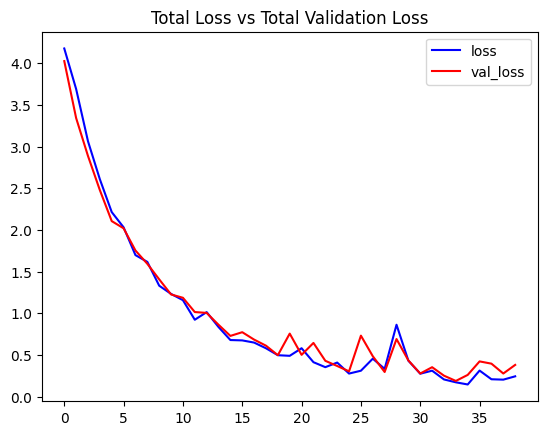

In [ ]:
# Visualize the training and validation loss metrices.
plot_metric(model_training_history, 'loss', 'val_loss', 'Total Loss vs Total Validation Loss')

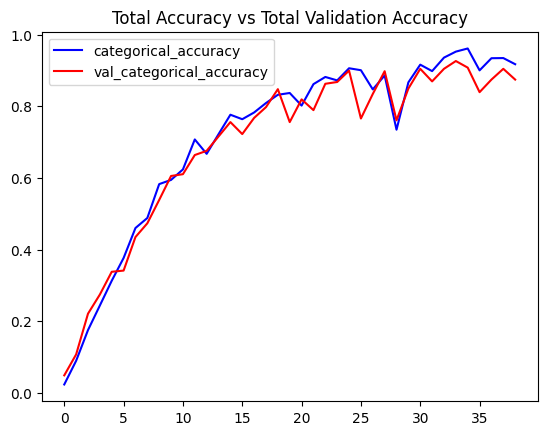

In [ ]:
# Visualize the training and validation accuracy metrices.
plot_metric(model_training_history, 'categorical_accuracy', 'val_categorical_accuracy', 'Total Accuracy vs Total Validation Accuracy')

In [ ]:
# Get predictions on test data
y_pred = model2.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


18/18 [==============================] - 1s 79ms/step


In [ ]:
# Classification Report
print("Classification Report:")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:

              precision    recall  f1-score   support



           0       1.00      1.00      1.00         8

           1       1.00      0.88      0.93         8

           2       1.00      0.88      0.93         8

           3       1.00      0.75      0.86         8

           4       1.00      1.00      1.00        15

           5       0.00      0.00      0.00         1

           6       1.00      1.00      1.00         8

           7       1.00      1.00      1.00         8

           8       1.00      1.00      1.00         8

           9       1.00      1.00      1.00         8

          10       1.00      1.00      1.00         8

          11       0.86      0.75      0.80         8

          12       0.78      0.88      0.82         8

          13       0.88      0.88      0.88         8

          14       0.88      0.88      0.88         8

          15       1.00      1.00      1.00         8

          16       1.00      0.75      

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.

  _warn_prf(average, modifier, msg_start, len(result))


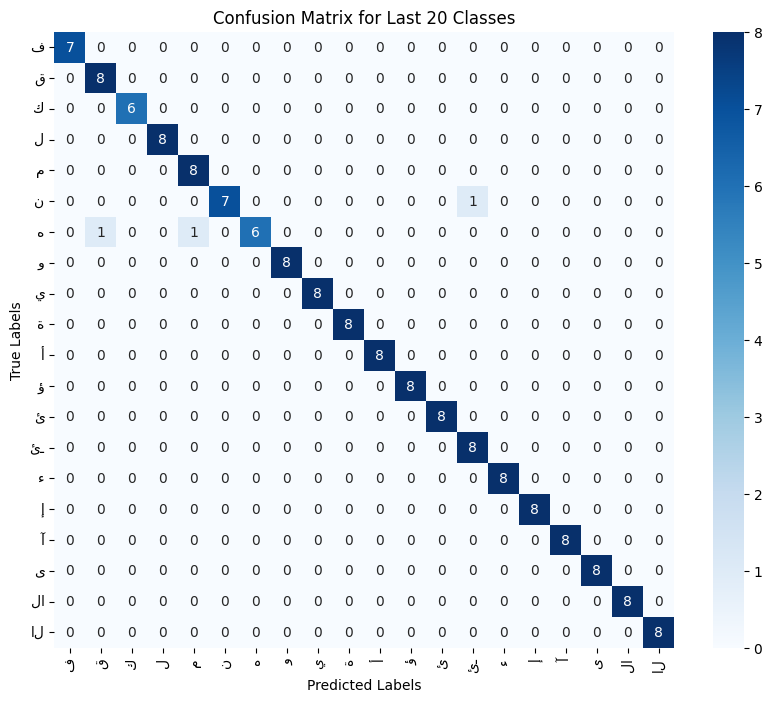

In [ ]:
# Select the last 20 classes
start_index = len(words2) - 20
cm_subset = cm[start_index:, start_index:]

# Define the class labels
class_labels = words2[start_index:]

# Create a figure and axis
plt.figure(figsize=(10, 8))
ax = sns.heatmap(cm_subset, annot=True, fmt='d', cmap='Blues')

# Set the axis labels and title
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix for Last 20 Classes')

# Set the x and y tick labels
ax.set_xticklabels(class_labels, rotation=90)
ax.set_yticklabels(class_labels, rotation=0)

# Show the plot
plt.show()

# **9.Make Predictions**

In [ ]:
#Predicted sign
res = model2.predict(X_test)
words2[np.argmax(res[1])]

18/18 [==============================] - 5s 136ms/step


'0'

In [ ]:
#Real sign
words2[np.argmax(y_test[1])]

'0'

In [ ]:
#Predicted sign
res = model2.predict(X_test)
words2[np.argmax(res[70])]

18/18 [==============================] - 1s 42ms/step


'8'

In [ ]:
#Real sign
words2[np.argmax(y_test[70])]

'8'

# **10. Save Model**

In [ ]:
model2.save('modeletter92%.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.

  saving_api.save_model(
